In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def calculate_histogram(image):
    histogram = np.zeros(256, dtype=int)
    
    for pixel_value in image.flatten():
        pixel_value = int(pixel_value)  # Convert to integer
        histogram[pixel_value] += 1
    
    return histogram


In [8]:
def clip_histogram(hist, clip_limit):
    clipped_hist = np.copy(hist)
    excess = 0
    
    for i in range(256):
        if clipped_hist[i] > clip_limit:
            excess += clipped_hist[i] - clip_limit
            clipped_hist[i] = clip_limit
        
    while excess > 0:
        for i in range(256):
            if clipped_hist[i] < clip_limit:
                to_borrow = min(excess, clip_limit - clipped_hist[i])
                clipped_hist[i] += to_borrow
                excess -= to_borrow
                if excess == 0:
                    break
    
    return clipped_hist

In [11]:
def redistribute_excess(hist, clip_limit):
    excess = 0
    
    for i in range(256):
        if hist[i] > clip_limit:
            excess += hist[i] - clip_limit
            hist[i] = clip_limit
    
    excess_per_bin = excess // 256
    
    for i in range(256):
        hist[i] += excess_per_bin
    
    return hist

In [12]:
def clahe(image, clip_limit, tile_size):
    height, width = image.shape
    
    padded_image = np.pad(image, pad_width=tile_size//2, mode='edge')
    
    equalized_image = np.zeros_like(image)
    
    for y in range(height):
        for x in range(width):
            tile = padded_image[y:y+tile_size, x:x+tile_size]
            tile_histogram = calculate_histogram(tile)
            clipped_histogram = clip_histogram(tile_histogram, clip_limit)
            
            cdf = clipped_histogram.cumsum()
            cdf_normalized = cdf / cdf[-1]
            
            mapping_function = np.interp(tile.flatten(), np.arange(256), cdf_normalized * 255)
            mapping_function_clipped = np.clip(mapping_function, 0, 255)
            
            equalized_tile = mapping_function_clipped.reshape(tile_size, tile_size)
            equalized_image[y, x] = equalized_tile[tile_size//2, tile_size//2]
    
    return equalized_image.astype(np.uint8)

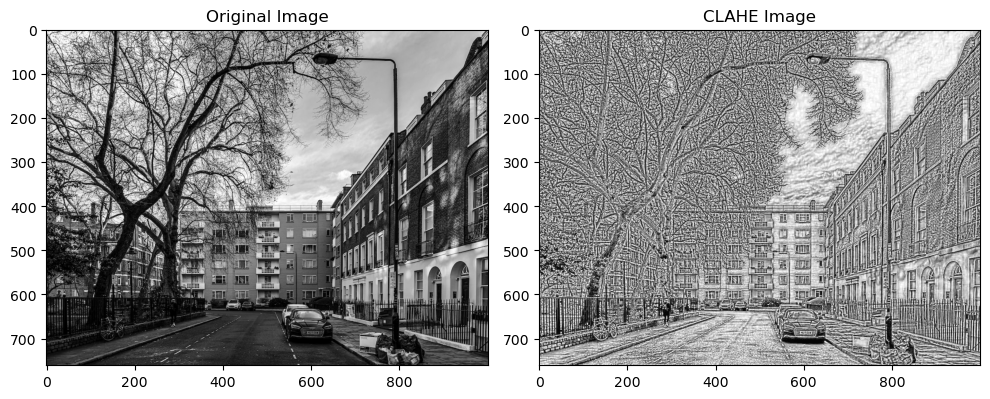

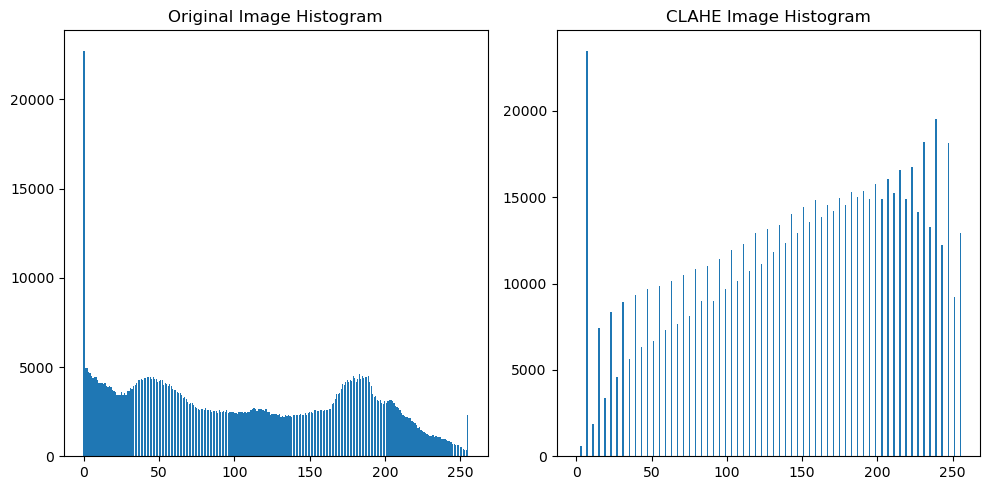

In [14]:

# Load the input image
input_image = plt.imread("City.jpg")

# Convert the image to grayscale if needed
if len(input_image.shape) == 3:
    input_image = input_image.mean(axis=2)

# Set the clip limit and tile size for CLAHE
clip_limit = 2.0
tile_size = 8

# Perform CLAHE
clahe_image = clahe(input_image, clip_limit, tile_size)

# Plot the original and CLAHE images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap="gray")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(clahe_image, cmap="gray")
plt.title("CLAHE Image")

plt.tight_layout()

# Plot histograms
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
hist_input = calculate_histogram(input_image)
plt.bar(range(256), hist_input)
plt.title("Original Image Histogram")

plt.subplot(1, 2, 2)
hist_clahe = calculate_histogram(clahe_image)
plt.bar(range(256), hist_clahe)
plt.title("CLAHE Image Histogram")

plt.tight_layout()
plt.show()
